Visualizing French projection layers
===============

```
./paradigm.py data/french.dat.gz --d_dense=256 --d_context=4 --d_rnn=256 --epochs=100  --verbose --dropout=0.2 --saveModel=french.json --saveWeights=french.h5
```

In [1]:
import numpy as np
import pandas as pd
import regex as re

from functools import reduce

import os
#os.environ['THEANO_FLAGS'] = 'device=cpu,mode=FAST_COMPILE'
import theano

from keras.models import model_from_json, Model

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 980 (0000:02:00.0)
Using Theano backend.


In [2]:
import time, sys, random
from collections import defaultdict, Counter

In [3]:
from sklearn.cluster import AffinityPropagation, KMeans
import sklearn.decomposition 
import sklearn.manifold
from sklearn.preprocessing import scale, normalize
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cosine

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
#import mpld3

plt.style.use('seaborn-paper')
plt.rcParams['font.sans-serif']= 'DejaVu Sans'
params = {'axes.linewidth':0.5}
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update(params)

Data setup 

This has to match what was done in paradigm.py when the model was trained.

In [5]:
data = pd.read_csv('data/french.dat.gz', sep='\t', names=['form', 'lexeme', 'features', 'lemma'])
data['form'] = [re.findall(r'\X', f) for f in data['form']]
MAXLEN = max(len(f) for f in data['form']) + 1

charset = sorted(reduce(set.union, map(set, data['form']))) + ['<', '>']
char_decode = dict(enumerate(charset))
char_encode = dict((c, i) for (i, c) in char_decode.items())
        
lexeme = dict((f,i) for (i,f) in enumerate(sorted(pd.unique(data['lexeme']))))
features = dict((f,i+len(lexeme)) for (i,f) in enumerate(sorted(pd.unique(data['features']))))

M = len(lexeme) + len(features)
C = len(charset)

Load models

In [6]:
model = model_from_json(open('french.json').read())
model.load_weights('french.h5')

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 5271)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 256)           1349632     input_1[0][0]                    
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 20, 40)        0                                            
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 20, 256)       0           dense_1[0][0]                    
___________________________________________________________________________________________

In [8]:
context = Model(input=model.get_layer('input_2').input,
             output=model.get_layer('timedistributed_1').output)

In [9]:
cell = Model(input=model.get_layer('input_1').input,
             output=model.get_layer('dense_1').output)

In [10]:
rnn = Model(input=[model.get_layer('input_1').input,model.get_layer('input_2').input],
             output=model.get_layer('lstm_1').output)

---

## Phoneme projection


In [11]:
X2 = np.zeros((C, MAXLEN, C), dtype=np.float32)
for i in range(C):
    X2[i, -1, i] = 1
weights = scale(context.predict(X2)[:,-1,:])

/opt/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


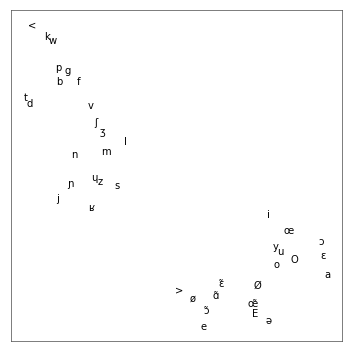

In [19]:
from sklearn.manifold import TSNE
best_kl = float('inf')
for i in range(25):
    tsne = TSNE(n_components=2, perplexity=5, n_iter=5000,verbose=False, method='exact', learning_rate=25)
    pts = tsne.fit_transform(weights)
    #pts = tsne.fit_transform(weights)
    if tsne.kl_divergence_ < best_kl:
        best = pts
        best_kl = tsne.kl_divergence_

plt.rcParams['figure.figsize']= '5,5'

plt.scatter(best[:,0],best[:,1], s=0)
for i in range(C):
    plt.annotate(char_decode[i], best[i,:], xytext=(0,0), textcoords='offset points', 
                 va='center', ha='center', size=10)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
#plt.savefig('figs/tsne.pdf')

In [22]:
def envs(s, n=10):
    pairs = Counter()
    for f in data['form']:
        f = ['<'] + f + ['>']
        i = 0
        while True:
            try:
                i = f.index(s, i)
                pairs[f[i-1]+f[i]+f[i+1]] += 1
                i = i + 1
            except ValueError:
                break
    return [x for x,y in pairs.most_common(n)]

In [23]:
print(pd.DataFrame(np.transpose([envs('p'),envs('b'),envs('f'),envs('v'),envs('ʃ'),envs('ʒ')])).to_latex(index=False))

\begin{tabular}{llllll}
\toprule
   0 &     1 &    2 &    3 &     4 &    5 \\
\midrule
 <pʁ &   <ba &  ifj &  <vi &   <ʃa &  <ʒa \\
 <pa &   <bʁ &  <fʁ &  <va &   aʃə &  aʒə \\
 <pl &   <bu &  ifi &  ava &  <ʃɑ̃ &  aʒi \\
 <pɛ &   <bi &  <fl &  avi &   Eʃi &  <ʒy \\
 <pi &   abi &  <fa &  Eva &   Eʃa &  aʒa \\
 <pO &   <bl &  <fi &  ivi &   <ʃi &  Eʒi \\
 <pE &  ɑ̃bʁ &  afi &  Evi &   ɔʃə &  ʁʒi \\
 Epa &   Ebʁ &  Efi &  uvʁ &   Oʃa &  ʁʒə \\
 api &   abl &  <fu &  iva &   aʃa &  aʒ> \\
 apʁ &   Ebu &  <fɔ &  əvi &  Eʃɑ̃ &  ʁʒa \\
\bottomrule
\end{tabular}



## Paradigm cell projection

In [25]:
N_data = len(data)
X1_data = np.zeros((N_data, M), dtype=np.float32)
for i, (form, lex, feat, lemma) in enumerate(data.itertuples(index=False)):
    X1_data[i, lexeme[lex]] = 1
    X1_data[i, features[feat]] = 1

In [26]:
rows = data['lexeme'] == 'paʁle'
labels = data['features'].values[np.ix_(rows)]
lexs = data['lexeme'].values[np.ix_(rows)]

In [27]:
X1_data = np.zeros((len(features), M), dtype=np.float32)
labels = [ ]
for i,feat in enumerate(features):
    X1_data[i, features[feat]] = 1
    labels.append(feat)
output = normalize(cell.predict(X1_data), axis=0)

In [30]:
best_kl = float('inf')
for i in range(25):
    tsne = TSNE(n_components=2, perplexity=10, n_iter=5000,verbose=False, method='exact', learning_rate=25)
    pts = tsne.fit_transform(output)
    #pts = tsne.fit_transform(weights)
    if tsne.kl_divergence_ < best_kl:
        best = pts
        best_kl = tsne.kl_divergence_

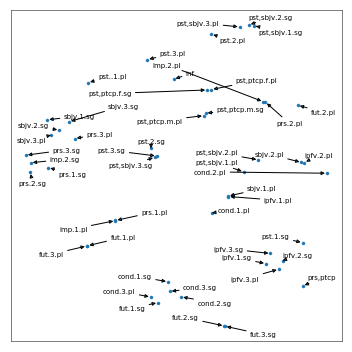

In [36]:
import adjustText

plt.interactive(True)
plt.rcParams['figure.figsize']= '5,5'

plt.scatter(best[:,0],best[:,1], s=10)
texts = [ ]
for i in range(output.shape[0]):
    texts.append(plt.text(best[i,0], best[i,1], labels[i], size=7))
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle="-|>",lw=1), force_text=.25, force_points=4)          
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
#plt.savefig('figs/vtsne.pdf')
#plt.savefig('figs/vtsne.svg')

## Plot recurrent layer

In [145]:
test = data.sample(100000)

N = sum(len(f)-1 for f in test['form'])
x1 = np.zeros((N, len(lexeme)+len(features)), dtype=np.bool)
x2 = np.zeros((N, MAXLEN, len(charset)), dtype=np.bool)

i = 0
for form, lex, feat, lemma in test.itertuples(index=False):
    form = form[:-1]
    for j in range(len(form)-1):
        x1[i, lexeme[lex]] = 1
        x1[i, features[feat]] = 1
        p = MAXLEN-(j+1)
        for k,c in enumerate(form[:j+1]):
            x2[i, p+k, char_encode[c]] = 1
        i += 1

In [146]:
y = rnn.predict([x1, x2])
pca = sklearn.decomposition.PCA(30, whiten=True)
pca.fit(y)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [106]:
def heatmap(lex, feats, do_pca=False):
    form = data[(data['lexeme']==lex)&(data['features']==feats)]['form']
    form = form.values[0]
    #form = form[1:-1]

    x1 = np.zeros((len(form)+1, len(lexeme)+len(features)), dtype=np.float32)
    x1[:,lexeme[lex]] = 1
    x1[:,features[feats]] = 1

    x2 = np.zeros((len(form)+1, MAXLEN, len(charset)), dtype=np.float32)
    x2[0,-1,char_encode['<']] = 1
    for i,c in enumerate(form):
        x2[i+1] = np.roll(x2[i], -1, axis=0)
        x2[i+1,-1,char_encode[c]] = 1
    y = rnn.predict([x1, x2])
    if do_pca:
        y = pca.transform(y)
    fig, ax = plt.subplots()
    ax.set_yticks(np.arange(y.shape[0]) + 0.5, minor=False)
    ax.set_yticklabels(['<'] + form, minor=False)
    plt.pcolor(y)

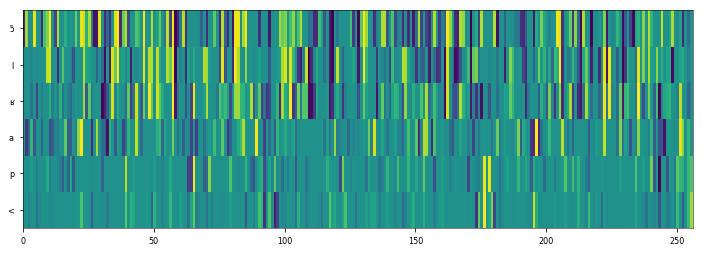

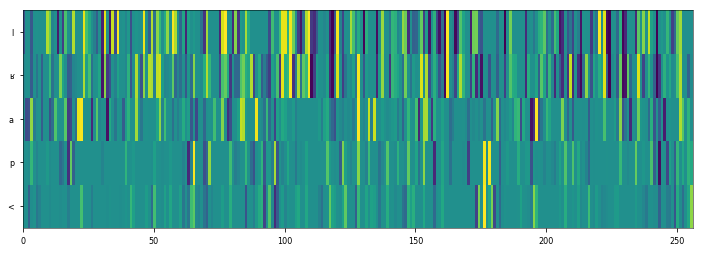

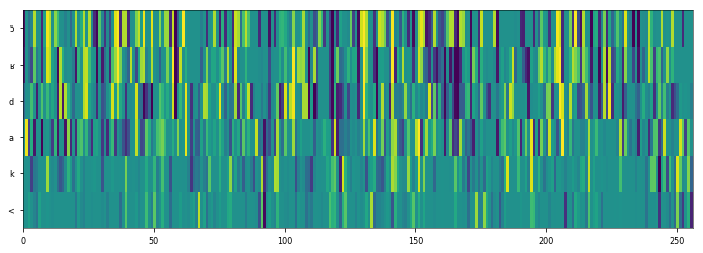

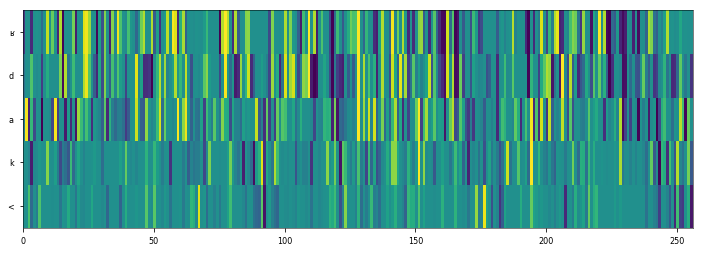

In [120]:
plt.rcParams['figure.figsize']= '12,4'
heatmap('parler','prs.1.pl')
heatmap('parler','prs.1.sg')
heatmap('cadrer','prs.1.pl')
heatmap('cadrer','prs.1.sg')

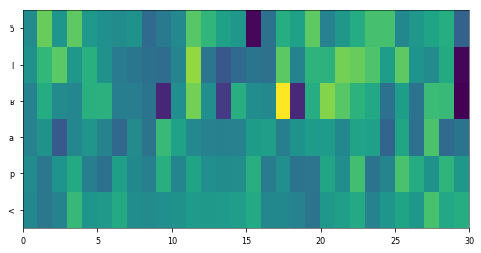

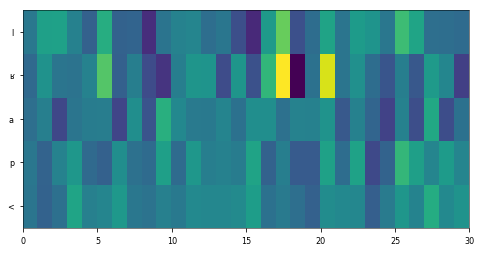

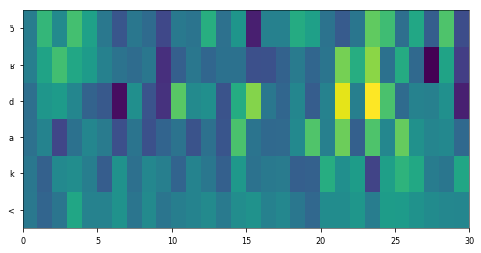

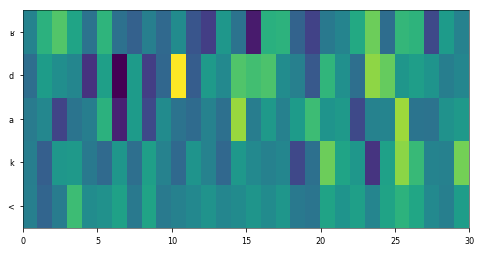

In [147]:
plt.rcParams['figure.figsize']= '8,4'
heatmap('parler','prs.1.pl', do_pca=True)
heatmap('parler','prs.1.sg', do_pca=True)
heatmap('cadrer','prs.1.pl', do_pca=True)
heatmap('cadrer','prs.1.sg', do_pca=True)

In [148]:
def trajectory(lex, feats):
    form = data[(data['lexeme']==lex)&(data['features']==feats)]['form']
    form = form.values[0]
    #form = form[1:-1]

    x1 = np.zeros((len(form)+1, len(lexeme)+len(features)), dtype=np.float32)
    x1[:,lexeme[lex]] = 1
    x1[:,features[feats]] = 1

    x2 = np.zeros((len(form)+1, MAXLEN, len(charset)), dtype=np.float32)
    x2[0,-1,char_encode['<']] = 1
    for i,c in enumerate(form):
        x2[i+1] = np.roll(x2[i], -1, axis=0)
        x2[i+1,-1,char_encode[c]] = 1
    y = rnn.predict([x1, x2])   
    yy = pca.transform(y)
    return form + ['>'], y, yy

In [228]:
def multiplot(lex, dim, forms=['prs.1.sg', 'prs.1.pl', 'ipfv.1.pl', 'fut.1.sg']):
    plt.rcParams['figure.figsize']= '4,1.25'
    plt.suptitle(lex+' (Component %d)'%(dim+1), size=8)
    plt.gcf().subplots_adjust(bottom=0.4)
    for i, feats in enumerate(forms):
        plt.subplot(1, len(forms), i+1)
        plt.tick_params(axis='y', labelleft='off')       
        f, t, tt = trajectory(lex, feats)
        plt.plot(tt[:,dim])
        plt.xticks(range(len(f)), f, size=8)
        plt.xlabel(feats, size=8)

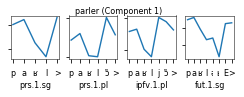

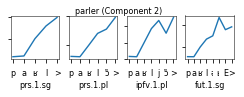

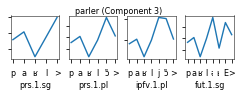

In [229]:
multiplot('parler', 0)
plt.savefig('figs/parler-1.pdf')
plt.show()
multiplot('parler', 1)
plt.savefig('figs/parler-2.pdf')
plt.show()
multiplot('parler', 2)
plt.savefig('figs/parler-3.pdf')
plt.show()

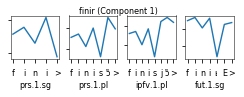

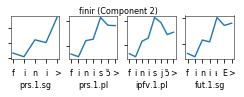

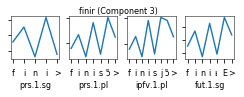

In [230]:
multiplot('finir', 0)
plt.savefig('figs/finir-1.pdf')
plt.show()
multiplot('finir', 1)
plt.savefig('figs/finir-2.pdf')
plt.show()
multiplot('finir', 2)
plt.savefig('figs/finir-3.pdf')
plt.show()

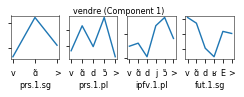

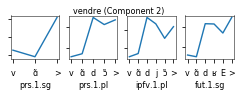

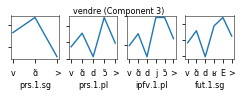

In [231]:
multiplot('vendre', 0)
plt.savefig('figs/vendre-1.pdf')
plt.show()
multiplot('vendre', 1)
plt.savefig('figs/vendre-2.pdf')
plt.show()
multiplot('vendre', 2)
plt.savefig('figs/vendre-3.pdf')
plt.show()

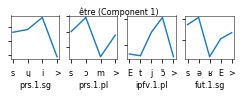

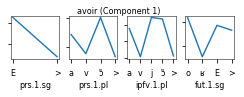

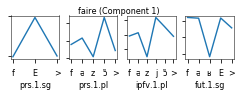

In [232]:
multiplot('être', 0, ['prs.1.sg', 'prs.1.pl', 'ipfv.1.pl', 'fut.1.sg'])
plt.savefig('figs/etre-1.pdf')
plt.show()
multiplot('avoir', 0)
plt.savefig('figs/avoir-1.pdf')
plt.show()
multiplot('faire', 0)
plt.savefig('figs/faire-1.pdf')
plt.show()


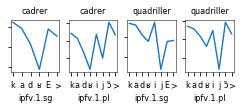

In [233]:
plt.rcParams['figure.figsize']= '4,1.24'
plt.gcf().subplots_adjust(bottom=0.3)
i = 1
for lex in ['cadrer', 'quadriller']:
    for feats in ['ipfv.1.sg', 'ipfv.1.pl']:
        plt.subplot(1, 4, i)
        plt.title(lex, size=8)
        plt.tick_params(axis='y', labelleft='off')       
        f, t, tt = trajectory(lex, feats)
        plt.plot(tt[:,0])
        plt.xticks(range(len(f)), f, size=8)
        plt.xlabel(feats, size=8)
        i += 1
plt.savefig('figs/cadrer.pdf')